In this notebook we will work with semantic segmentation task using this [dataset](https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation?resource=download)

# Installing dependencies

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os

import cv2
from sklearn.model_selection import train_test_split
from PIL import Image

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from time import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!nvidia-smi

Sun Sep 15 11:30:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [8]:
!unzip -q /content/gdrive/MyDrive/archiveSeg.zip

In [9]:
!ls people_segmentation

images	masks  README  segmentation


# Load dataset

In [10]:
TRAIN_PATH = './people_segmentation/segmentation/train.txt'
VAL_PATH = './people_segmentation/segmentation/val.txt'
IMAGES_PATH = './people_segmentation/images/'
MASKS_PATH = './people_segmentation/masks/'

In [11]:
class ImageDataset(Dataset):
    def __init__(self, split_file):
        self.split_file = split_file

        # Read the split file and store the file names
        with open(self.split_file, 'r') as f:
            self.file_names = f.read().splitlines()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(IMAGES_PATH, self.file_names[idx] + '.jpg')
        mask_name = os.path.join(MASKS_PATH, self.file_names[idx] + '.png')

        image = self.load_sample(img_name)
        mask = self.load_sample(mask_name)

        image, mask = self._prepare_sample(image), self._prepare_sample(mask)
        mask = self._binarize_mask(mask)

        transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # apply normalization from ImageNet dataset
        ])

        image = transform(image)

        return image, mask

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        resize = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        return resize(image)

    def _binarize_mask(self, mask):
        mask = (mask != 0).type(torch.float)
        return mask

In [12]:
train_dataset = ImageDataset(TRAIN_PATH)
val_dataset = ImageDataset(VAL_PATH)

In [13]:
print(f'Len train: {len(train_dataset)}', f'Len val: {len(val_dataset)}', sep='\n')

Len train: 5110
Len val: 568


In [14]:
def plot_pairs(df, amount_displayed=5):
    plt.figure(figsize=(10, 5))
    for i in range(amount_displayed):
        image, mask = df[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(mask.squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

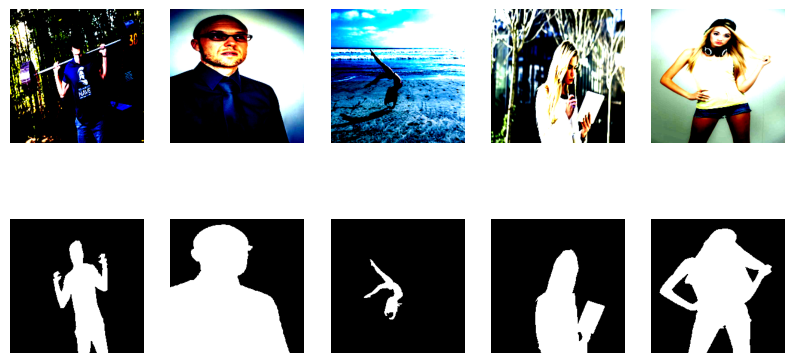

In [15]:
plot_pairs(train_dataset, amount_displayed=5)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define additional functions

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # Apply argmax if the output has multiple classes (i.e., softmax output)

    # Ensure that both outputs and labels are binary (0 or 1)
    outputs = outputs.byte()  # Convert outputs to binary
    labels = labels.byte()    # Convert labels to binary

    SMOOTH = 1e-8  # Small constant to avoid division by zero

    # Calculate intersection and union
    intersection = (outputs & labels).float().sum((1, 2))  # Sum over H x W dimensions for each image in the batch
    union = (outputs | labels).float().sum((1, 2))         # Sum over H x W dimensions for each image in the batch

    # Compute IoU score
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # Add SMOOTH to avoid division by zero

    return iou

In [18]:
def bce_loss(y_real, y_pred):
    return (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred))).sum()

In [19]:
def show_model_pred(model, data):
    X_val, Y_val = next(iter(data))

    model.eval()
    Y_hat = model(X_val[:6].to(device)).detach().cpu()
    for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

# Define train

In [20]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    for epoch in range(epochs):
        start  = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            train_loss += loss / len(data_tr)
        print('Train loss: %f' % train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                Y_val_pred = model(X_val_batch)
                val_loss += loss_fn(Y_val_batch, Y_val_pred) / len(data_val)
        print('Validation loss: %f' % val_loss)
        end  = time()
        print(f'Time spent: {end-start}')

        history.append((train_loss, val_loss))

    show_model_pred(model, data_val)
    return history

In [21]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [33]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

        del Y_pred, Y_label, X_batch
        torch.cuda.memory.empty_cache()
    return scores/len(data)

# Define models architecture

In [23]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

# Training

Let's try to train the custom network on 20 epochs

In [ ]:
unet_basic = UNet().to(device)

* Epoch 1/20
Train loss: 351829.093750
Validation loss: 313162.000000
Time spent: 198.70328903198242
* Epoch 2/20
Train loss: 280689.156250
Validation loss: 291411.687500
Time spent: 196.4026656150818
* Epoch 3/20
Train loss: 247366.156250
Validation loss: 242717.578125
Time spent: 198.12314915657043
* Epoch 4/20
Train loss: 221336.812500
Validation loss: 209796.953125
Time spent: 196.19241189956665
* Epoch 5/20
Train loss: 204127.781250
Validation loss: 206715.500000
Time spent: 198.71794724464417
* Epoch 6/20
Train loss: 190886.968750
Validation loss: 181689.859375
Time spent: 196.38160586357117
* Epoch 7/20
Train loss: 175919.906250
Validation loss: 168276.203125
Time spent: 198.7011525630951
* Epoch 8/20
Train loss: 167857.000000
Validation loss: 170674.796875
Time spent: 197.6553030014038
* Epoch 9/20
Train loss: 155555.453125
Validation loss: 162299.250000
Time spent: 198.22319674491882
* Epoch 10/20
Train loss: 148780.812500
Validation loss: 150523.031250
Time spent: 196.2189218

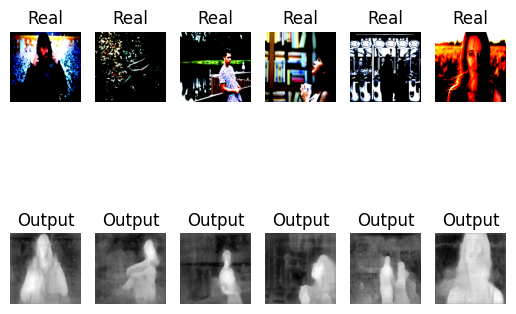

In [ ]:
optim = torch.optim.Adam(unet_basic.parameters(), lr=1e-3)
history_unet_basic = train(unet_basic, optim, bce_loss, 20, train_loader, val_loader)

In [ ]:
file_path = 'unet_basic_model.pth'

# Save the model
torch.save(unet_basic.state_dict(), file_path)

In [ ]:
score_model(unet_basic, iou_pytorch, val_loader)

0.6039930648273892

In [24]:
def plot_learning_curves(history):
    loss = [d[0].detach().cpu().numpy() for d in history]
    val_loss = [d[1].detach().cpu().numpy() for d in history]
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

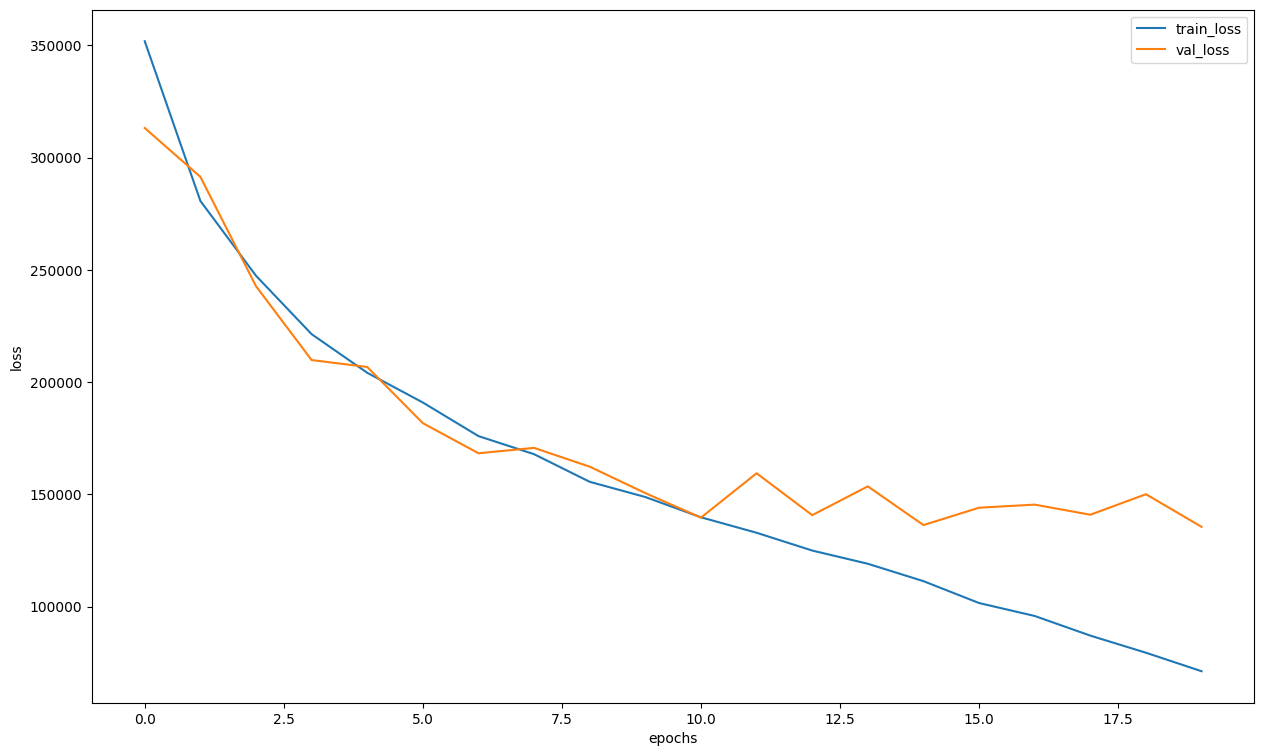

In [ ]:
plot_learning_curves(history_unet_basic)

As we can see, the loss function has not reached a plateau, so let's add another 7 epochs for training

In [ ]:
weights = torch.load('unet_basic_model.pth')

unet_basic_2 = UNet().to(device)

unet_basic_2.load_state_dict(weights)

<ipython-input-30-37eb86b5dc3c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('unet_basic_model.pth')


<All keys matched successfully>

* Epoch 1/7
Train loss: 64800.890625
Validation loss: 133159.843750
Time spent: 198.65982580184937
* Epoch 2/7
Train loss: 64643.261719
Validation loss: 138332.890625
Time spent: 196.09016466140747
* Epoch 3/7
Train loss: 64639.312500
Validation loss: 137317.296875
Time spent: 197.765851020813
* Epoch 4/7
Train loss: 64538.054688
Validation loss: 134466.562500
Time spent: 195.84209203720093
* Epoch 5/7
Train loss: 64869.167969
Validation loss: 135638.359375
Time spent: 197.55432605743408
* Epoch 6/7
Train loss: 64468.328125
Validation loss: 136123.671875
Time spent: 195.9266710281372
* Epoch 7/7
Train loss: 64719.429688
Validation loss: 136365.500000
Time spent: 197.64237666130066


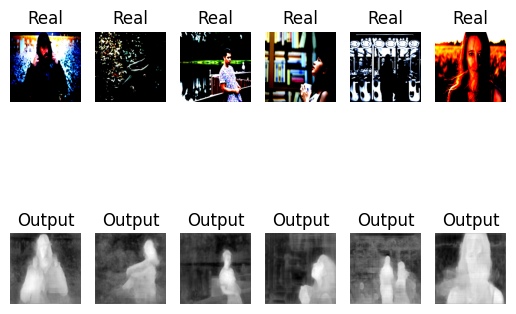

In [ ]:
history_unet_basic_2 = train(unet_basic_2, optim, bce_loss, 7, train_loader, val_loader)

In [ ]:
file_path = 'unet_basic_model2.pth'

# Save the model
torch.save(unet_basic_2.state_dict(), file_path)

In [ ]:
score_model(unet_basic_2, iou_pytorch, val_loader)

0.5531250105963813

In [ ]:
whole_unet_history = history_unet_basic.copy()

In [ ]:
whole_unet_history.extend(history_unet_basic_2)

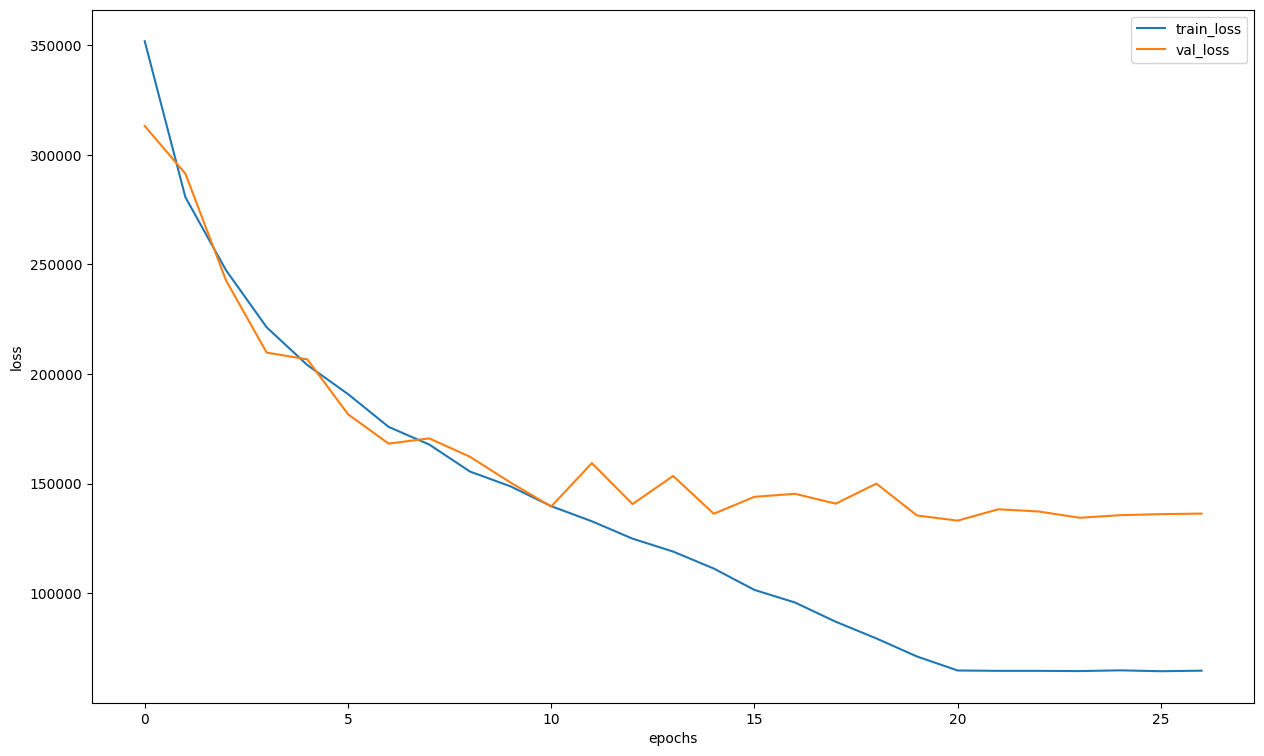

In [ ]:
plot_learning_curves(whole_unet_history)

Now, let's try to use a pretrained network

In [27]:
import segmentation_models_pytorch as smp

In [28]:
unet_pretrained = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.5MB/s]


In [29]:
unet_pretrained = unet_pretrained.to(device)
unet_pretrained

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

* Epoch 1/25
Train loss: 200464.093750
Validation loss: 175718.203125
Time spent: 82.15861463546753
* Epoch 2/25
Train loss: 150271.156250
Validation loss: 152254.453125
Time spent: 77.0910108089447
* Epoch 3/25
Train loss: 124809.726562
Validation loss: 129293.515625
Time spent: 78.1174521446228
* Epoch 4/25
Train loss: 120007.007812
Validation loss: 120209.171875
Time spent: 79.55647492408752
* Epoch 5/25
Train loss: 108736.132812
Validation loss: 131794.375000
Time spent: 79.94529271125793
* Epoch 6/25
Train loss: 96915.570312
Validation loss: 126608.546875
Time spent: 79.46238398551941
* Epoch 7/25
Train loss: 87860.492188
Validation loss: 123310.984375
Time spent: 78.17079186439514
* Epoch 8/25
Train loss: 75839.734375
Validation loss: 115422.453125
Time spent: 80.26405668258667
* Epoch 9/25
Train loss: 82097.265625
Validation loss: 148684.687500
Time spent: 79.3140618801117
* Epoch 10/25
Train loss: 74905.156250
Validation loss: 133680.578125
Time spent: 80.64098501205444
* Epoch

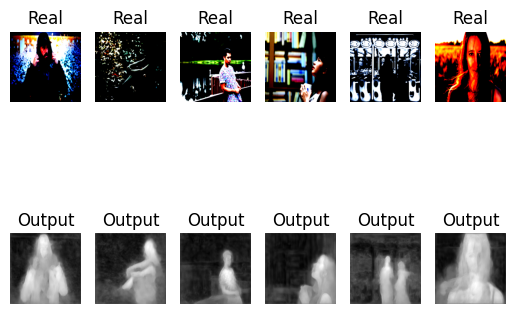

In [30]:
optim = torch.optim.Adam(unet_pretrained.parameters(), lr=1e-3)
history_unet_pretrained = train(unet_pretrained, optim, bce_loss, 25, train_loader, val_loader)

In [31]:
file_path = 'unet_pretrained_model.pth'

# Save the model
torch.save(unet_pretrained.state_dict(), file_path)

Validation IoU score

In [35]:
score_model(unet_pretrained, iou_pytorch, val_loader)

0.8605300320519341

Train IoU score

In [37]:
score_model(unet_pretrained, iou_pytorch, train_loader)

0.9400716304779053

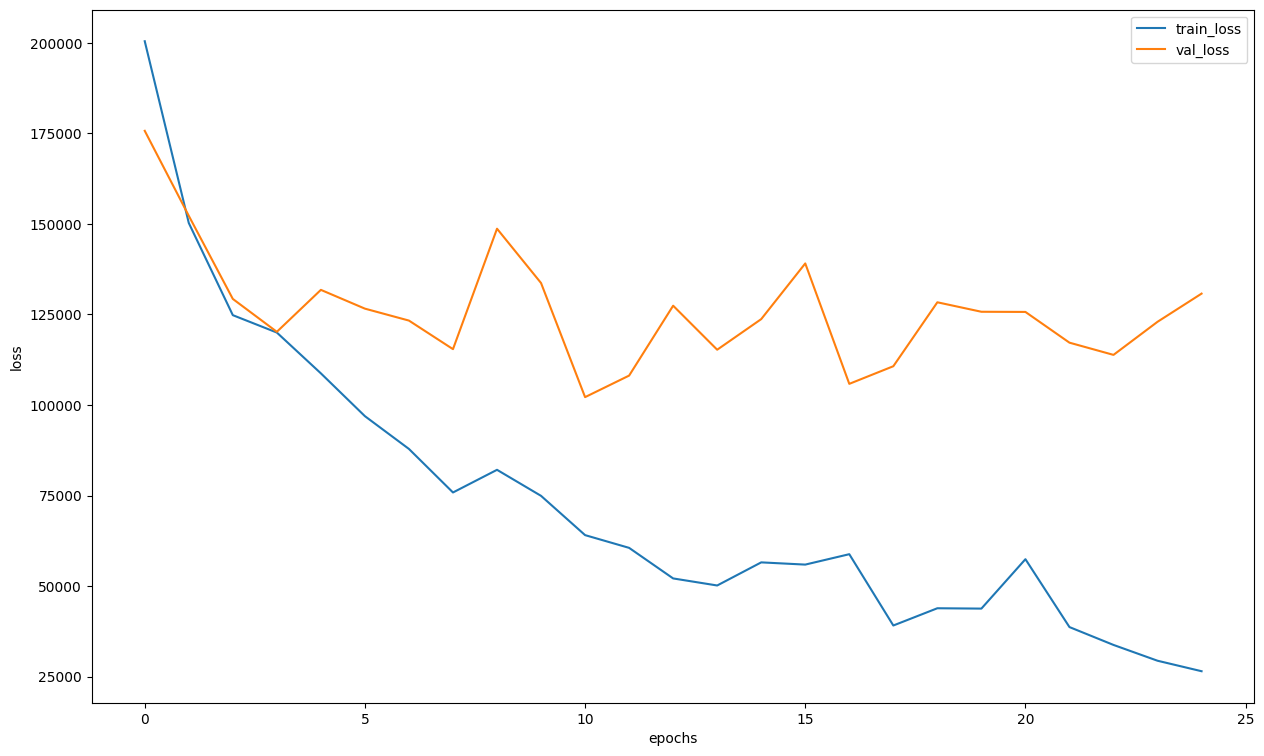

In [36]:
plot_learning_curves(history_unet_pretrained)

# Conclusion

Experiments were conducted where we compared the results of the IoU metric for the custom Unet model and its pretrained version and obtained the following best results for each of them:
* custom Unet model - 0.6039 (additional training did not improve the result)
* pretrained Unet - 0.8605

The largest value obtained is 0.
6039 for the network trained from scratch and 0.8605 for the pretrained one can be called quite good indicators.